# Project 1: Crowd counting in beaches.
---
<br>
Authors: Micha Fauth & Antoni Bennasar Garau

In [1]:
import cv2
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import numpy as np

# Add the 'src' directory to the Python path
sys.path.append(os.path.join(os.getcwd(), 'src'))

In [2]:
#Loading file images.
folder_path = 'data/images'
# List all files and directories in the specified folder
all_files = os.listdir(folder_path)
# Filter to get only files (exclude directories)
file_names = [file for file in all_files if os.path.isfile(os.path.join(folder_path, file))]

def import_labels(image_name):
    image_name = os.path.splitext(image_name)[0]
    csv_path = f"data/labels/labels_{image_name}.csv"
    data = pd.read_csv(csv_path)
    #data = data.drop(["Label" ,"X ","Y"], axis=1)
    #data = data.drop([3 ,4,5], axis=1)
    return data
    
labels = import_labels(file_names[0])
labels.head()

,Label,X,Y,Image,Width,Height
0,Person,1484,824,1660572000.jpg,1920,1080
1,Person,206,822,1660572000.jpg,1920,1080
2,Person,444,735,1660572000.jpg,1920,1080
3,Person,510,726,1660572000.jpg,1920,1080
4,Person,265,690,1660572000.jpg,1920,1080


## Example of crowd image
---
<br>


/var/folders/1s/kr8rp_7x0vx66z2268zj7xjm0000gn/T/ipykernel_40588/3258269741.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cv2.circle(points_img, (row[1],row[2]), radius=5, color=(0, 255, 0), thickness=-1)


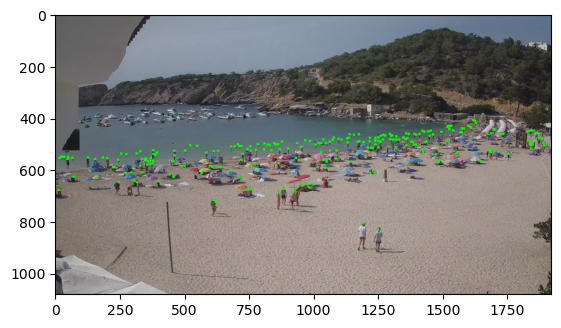

In [3]:
img= cv2.imread(f"data/images/{file_names[1]}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

points_img = img.copy()
labels = import_labels(file_names[1])
for _, row in labels.iterrows():
    # cv2.circle(image, center, radius, color, thickness)
    cv2.circle(points_img, (row[1],row[2]), radius=5, color=(0, 255, 0), thickness=-1)

plt.imshow(points_img)
plt.show()


### Baseline
---
<br>
This is (intentionally) left as a very open-ended question: you should decide which techniques to apply (and why!) some ideas:  

1. Image averaging.
2. Histogram equalization/CLAHE.
3. Pixel-wise comparison with “empty” beach (image averaging).
4. Spatial filters: derivatives, laplacian.
5. Kernels specifically designed for crowd counting
6. Morphological thinning.
7. Edge detectors.


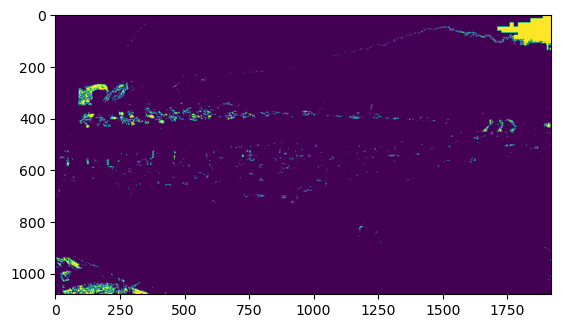

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
empty_beach = cv2.imread("data/images/0_empty.jpg", cv2.IMREAD_GRAYSCALE)
difference = cv2.absdiff(empty_beach, gray)
_, thresholded = cv2.threshold(difference, 90, 255, cv2.THRESH_BINARY) #75-255
plt.imshow(thresholded)

## Applying Gaussian blurr
LOREM IPSUM LOREM IPSUM

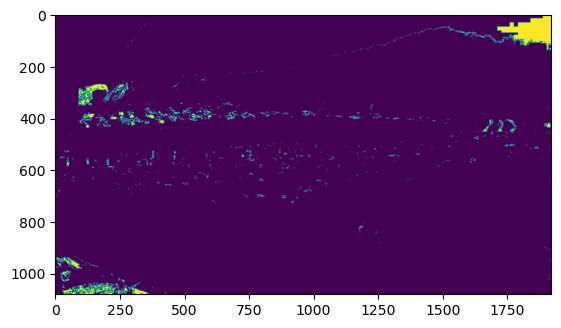

In [5]:
n = cv2.GaussianBlur(thresholded, (3,3), 1.4)
plt.imshow(n)

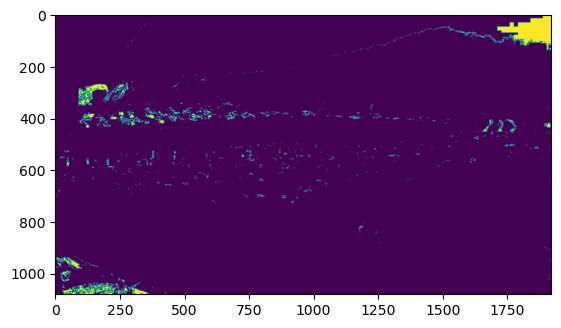

In [6]:
kernel = np.ones((1, 1), np.uint8)
closed_image = cv2.morphologyEx(n, cv2.MORPH_CLOSE, kernel)
plt.imshow(closed_image)

## RESULT

En la imagen se ve como ha detectado un porcentaje de personas pero también detecta objetos no iteresados como la montaña y las barcas.

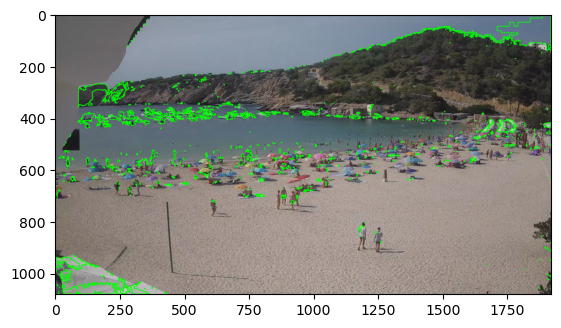

In [7]:
img_contours = img.copy()
contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)
plt.imshow(img_contours)

## Defining a region of interest
LOREM IPSUM LOREM IPSUMLOREM IPSUM LOREM IPSUMLOREM IPSUM LOREM IPSUMLOREM IPSUM LOREM IPSUMLOREM IPSUM LOREM IPSUM

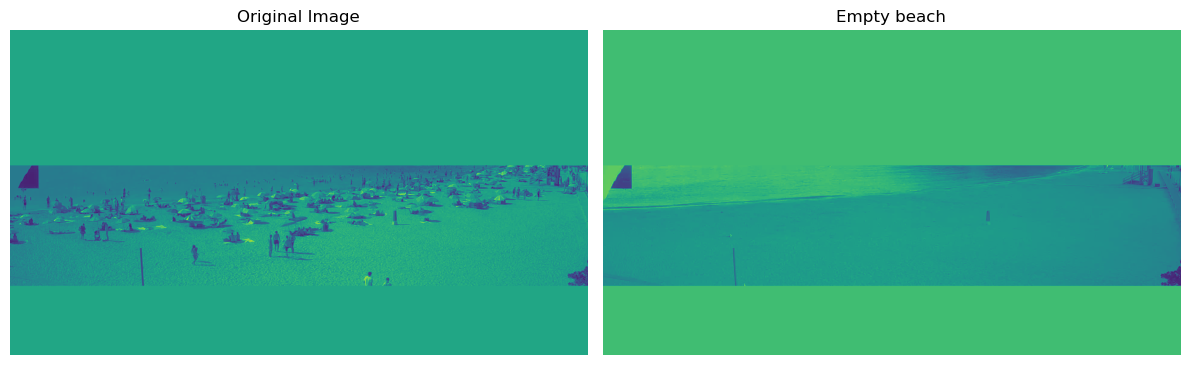

In [8]:
x1, y1 = 0, 0  # Esquina superior izquierda de la zona
x2, y2 = 2000, 450 #500 
gray[y1:y2, x1:x2] = 150
empty_beach[y1:y2, x1:x2] = 150

x1, y1 = 0, 850  # Esquina superior izquierda de la zona
x2, y2 = 2000, 1100 
gray[y1:y2, x1:x2] = 150
empty_beach[y1:y2, x1:x2] = 150

fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Display the images
ax[0].imshow(gray)
ax[0].axis('off')  # Turn off axis for the first image
ax[0].set_title('Original Image')  # Title for the first image

ax[1].imshow(empty_beach)
ax[1].axis('off')  # Turn off axis for the second image
ax[1].set_title('Empty beach')  # Title for the second image

# Show the images
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

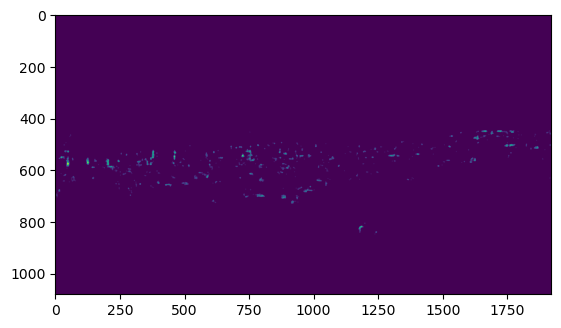

In [9]:
difference = cv2.absdiff(empty_beach, gray)

# Aplicar el umbral en la diferencia
_, thresholded = cv2.threshold(difference, 90, 255, cv2.THRESH_BINARY)
n = cv2.GaussianBlur(thresholded, (5,5), 1.4)
kernel = np.ones((5, 5), np.uint8)
closed_image = cv2.morphologyEx(n, cv2.MORPH_CLOSE, kernel)
plt.imshow(closed_image)

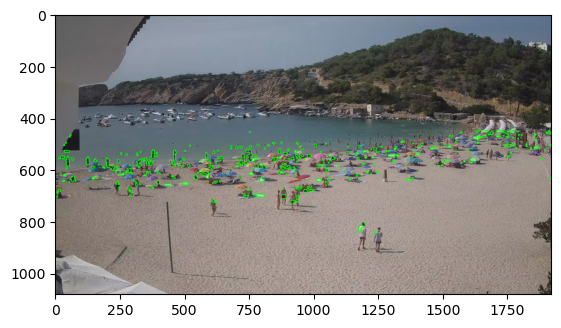

In [10]:
img_contours = img.copy()
contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)
plt.imshow(img_contours)

In [11]:
print(len(contours))

234


In [12]:
# Iterate through each contour
points = []
def calculate_points_from_contours(contours):
    results = []
    for contour in contours:
        # Calculate moments
        M = cv2.moments(contour)
        
        # Compute the centroid if the area is not zero
        if M["m00"] != 0:
            C_x = int(M["m10"] / M["m00"])
            C_y = int(M["m01"] / M["m00"])
            results.append([C_x,C_y])
        # else:
        #     C_x, C_y = 0, 0  # Default values if the area is zero
    return results


points = calculate_points_from_contours(contours)
print(len(points))

234


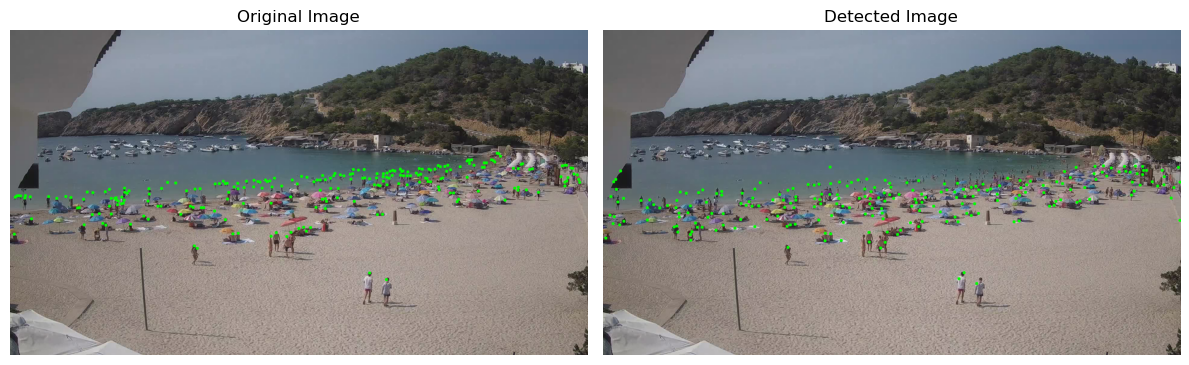

In [13]:
points_img2 = img.copy()

for x,y in points:
    # cv2.circle(image, center, radius, color, thickness)
    cv2.circle(points_img2, (x,y), radius=5, color=(0, 255, 0), thickness=-1)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Display the images
ax[0].imshow(points_img)
ax[0].axis('off')  # Turn off axis for the first image
ax[0].set_title('Original Image')  # Title for the first image

ax[1].imshow(points_img2)
ax[1].axis('off')  # Turn off axis for the second image
ax[1].set_title('Detected Image')  # Title for the second image

# Show the images
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [14]:
actual_points = []
for _, row in labels.iterrows():
    actual_points.append([row[1],row[2]])
actual_points = np.array(actual_points)
points = np.array(points)

/var/folders/1s/kr8rp_7x0vx66z2268zj7xjm0000gn/T/ipykernel_40588/3739729304.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_points.append([row[1],row[2]])


In [16]:
from scipy.spatial import cKDTree

tree = cKDTree(points)
# Encontrar el punto real más cercano para cada punto predicho
distances, indexs = tree.query(actual_points)
threshold = 10  # Adjust this value based on your specific use case
# Count the number of points within the threshold
num_accurate_points = np.sum(distances <= threshold)
# Calculate percentage accuracy
percentage_accuracy = (num_accurate_points / len(actual_points)) * 100

print(len(actual_points))
print("Number of points within the threshold:", num_accurate_points)
print("Percentage accuracy:", percentage_accuracy)

squared_errors = distances**2  # Squared Euclidean distance
# Calculate the Mean Squared Error (MSE)
mse = np.mean(squared_errors)
print("Mean Squared Error:", mse)

def evaluate_detection(ground_truth_points,predicted_points,threshold=10):
    tree = cKDTree(predicted_points)
    # Encontrar el punto real más cercano para cada punto predicho
    distances, indexs = tree.query(ground_truth_points)
    #threshold = 10  # Adjust this value based on your specific use case
    # Count the number of points within the threshold
    num_accurate_points = np.sum(distances <= threshold)
    # Calculate percentage accuracy
    percentage_accuracy = (num_accurate_points / len(actual_points)) * 100

    print(len(actual_points))
    print("Number of points within the threshold:", num_accurate_points)
    print("Percentage accuracy:", percentage_accuracy)
    squared_errors = distances**2  # Squared Euclidean distance
    # Calculate the Mean Squared Error (MSE)
    mse = np.mean(squared_errors)
    print("Mean Squared Error:", mse)


235
Number of points within the threshold: 83
Percentage accuracy: 35.319148936170215
Mean Squared Error: 551.3659574468085


In [35]:
img_2= cv2.imread(f"data/images/{file_names[1]}")
empty_beach2= cv2.imread("data/images/0_empty.jpg")


In [36]:
lab_image = cv2.cvtColor(img_2, cv2.COLOR_BGR2LAB)

# Split LAB channels
l_channel, a_channel, b_channel = cv2.split(lab_image)

# Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L-channel
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
l_channel_equalized = clahe.apply(l_channel)

# Merge channels back
lab_image_equalized = cv2.merge((l_channel_equalized, a_channel, b_channel))

# Convert back to BGR color space
shadow_removed_image2 = cv2.cvtColor(lab_image_equalized, cv2.COLOR_LAB2BGR)

In [37]:
lab_image = cv2.cvtColor(empty_beach2, cv2.COLOR_BGR2LAB)

# Split LAB channels
l_channel, a_channel, b_channel = cv2.split(lab_image)

# Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L-channel
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
l_channel_equalized = clahe.apply(l_channel)

# Merge channels back
lab_image_equalized = cv2.merge((l_channel_equalized, a_channel, b_channel))

# Convert back to BGR color space
shadow_removed_image = cv2.cvtColor(lab_image_equalized, cv2.COLOR_LAB2BGR)

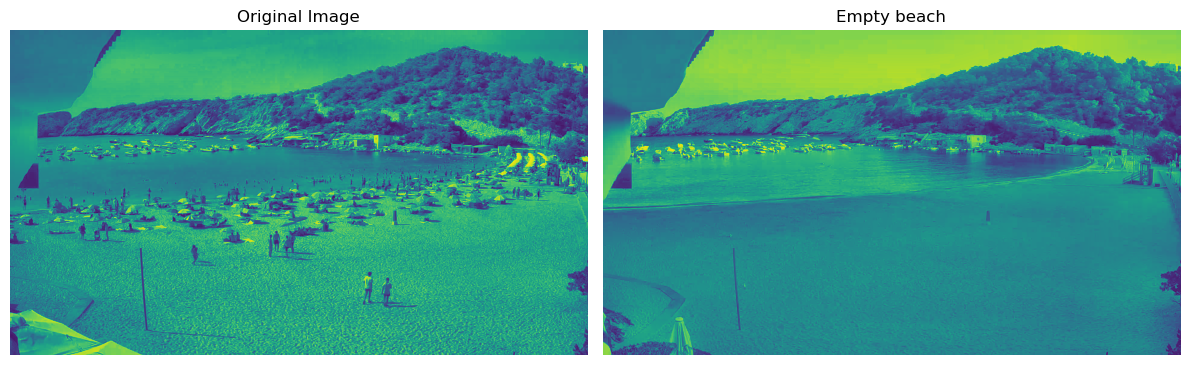

In [38]:
gray2 = cv2.cvtColor(shadow_removed_image2, cv2.COLOR_BGR2GRAY)
empty_beach2 = cv2.cvtColor(shadow_removed_image, cv2.COLOR_BGR2GRAY)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Display the images
ax[0].imshow(gray2)
ax[0].axis('off')  # Turn off axis for the first image
ax[0].set_title('Original Image')  # Title for the first image

ax[1].imshow(empty_beach2)
ax[1].axis('off')  # Turn off axis for the second image
ax[1].set_title('Empty beach')  # Title for the second image

# Show the images
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [39]:
x1, y1 = 0, 0  # Esquina superior izquierda de la zona
x2, y2 = 2000, 430 #500 
gray2[y1:y2, x1:x2] = 150
empty_beach2[y1:y2, x1:x2] = 150

x1, y1 = 0, 850  # Esquina superior izquierda de la zona
x2, y2 = 2000, 1100 
gray2[y1:y2, x1:x2] = 150
empty_beach2[y1:y2, x1:x2] = 150

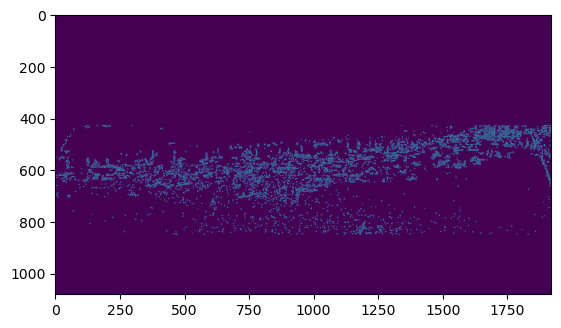

In [40]:
diff_image = cv2.absdiff(gray2, empty_beach2)

# Apply a binary threshold to highlight differences
_, thresh_image = cv2.threshold(diff_image, 90, 255, cv2.THRESH_BINARY)
edges = cv2.Canny(thresh_image, threshold1=30, threshold2=120)
plt.imshow(edges)

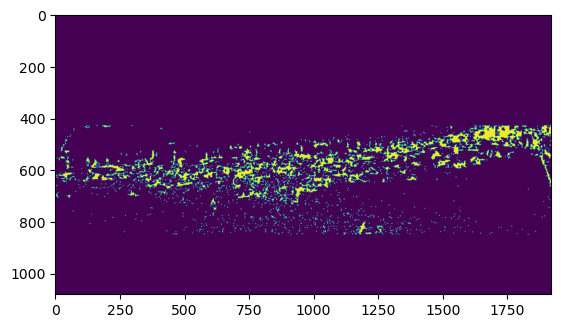

In [41]:
# Morphological operations to refine contours
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
dilated = cv2.dilate(edges, kernel, iterations=1)
eroded = cv2.erode(dilated, kernel, iterations=1)
plt.imshow(eroded)


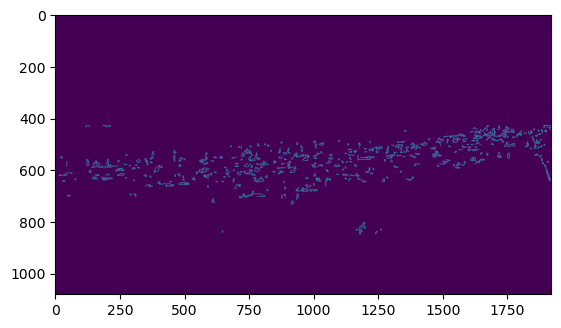

In [42]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(edges, connectivity=8)

# Filter small components by area
min_area = 15  # Minimum area to keep (adjust based on your image size)
filtered_image = np.zeros_like(thresh_image)

for i in range(1, num_labels):  # Skip the background (label 0)
    if stats[i, cv2.CC_STAT_AREA] >= min_area:
        filtered_image[labels == i] = 255
plt.imshow(filtered_image)

235
Number of points within the threshold: 55
Percentage accuracy: 23.404255319148938
Mean Squared Error: 384.9914893617021


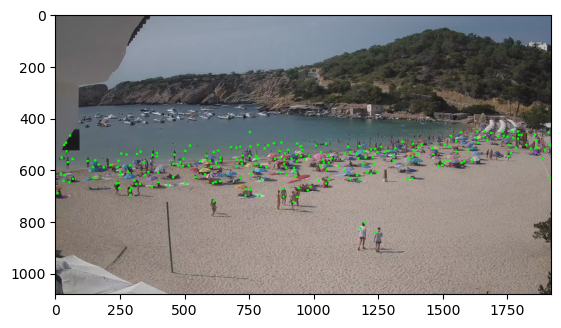

In [43]:
points_img4 = img.copy()
contours, _ = cv2.findContours(filtered_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  # Convert to BGR for color drawing
#cv2.drawContours(points_img4, contours, -1, (0, 255, 0), 2)
for x,y in points:
    # cv2.circle(image, center, radius, color, thickness)
    cv2.circle(points_img4, (x,y), radius=5, color=(0, 255, 0), thickness=-1)
plt.imshow(points_img4)

predicted_points = calculate_points_from_contours(contours)
evaluate_detection(actual_points,predicted_points,threshold=5)